In [1]:
import os, sys
from tqdm import tqdm
import seaborn as sns
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules.preprocessing import *
from modules.io import *
from modules.learning import *
from modules.patterns import *
from modules.statistics import *
from modules.plots import *
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import normalize
import seaborn
import pickle
from tqdm.notebook import tqdm
plt.style.use('ggplot')

# Detect with static yaw with a different approach (regression that fits best)

# Load Data

In [2]:
dataset_file = '/data/data2/engie_initial/post_treated_data/BEZ/BEBEZE03_scada_high_frequency.parquet'
df = load_df(dataset_file)
df = df.dropna(axis=1, how='all')
df.columns = df.columns.str.replace('cor. ', '', regex=False)

In [3]:
cols = ['wind speed', 'pitch angle', 'rotor speed', 'active power',
        'nacelle direction', 'wind direction']
df = df[cols]

# Resample and apply filters

In [4]:
df.head()

,wind speed,pitch angle,rotor speed,active power,nacelle direction,wind direction
datetime,,,,,,
2018-01-02 00:00:00,11.689011,4.920000,13.099948,1670.194214,225.560364,219.963791
2018-01-02 00:00:02,10.209633,3.107840,13.768863,1734.004761,225.560364,221.596112
2018-01-02 00:00:04,9.639848,2.857445,13.966517,1798.870400,225.560364,226.059685
2018-01-02 00:00:06,9.407192,2.607051,14.164171,1825.356445,225.560364,222.380832
2018-01-02 00:00:08,9.367785,2.356656,14.353823,1939.916748,225.560364,215.048021


In [5]:
def outliers_IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_iqr = df[~((df < (Q1 - 1.5 * IQR)) | (df >(Q3 + 1.5 * IQR))).any(axis=1)]
    return df_iqr

# Resample with 60second granularity
df=change_granularity(df,granularity='1min')

df["theta_d"] = (df['wind direction'] - df['nacelle direction']) % 360
df["theta_d"][df["theta_d"] > +180] -= 360
df["theta_d"][df["theta_d"] < -180] += 360
df["theta_d"] = df["theta_d"].rolling(60).mean()
df = df.dropna()

df_initial = df.copy()

# Perform IQR outlier removal
df = outliers_IQR(df)
print(df.shape)

# drop values of wind speed under 5m/s
df=filter_col(df, 0, less_than=5, bigger_than=11)

# drop values with pitch angle higher than 2 degrees or lower than -2 degrees
df=filter_col(df, 1, less_than=-2, bigger_than=2)

# drop values of rotor speed under 8rpm
df=filter_col(df, 2, less_than=8, bigger_than=15)

# drop values of power near the power_limit and near or below zero
power_limit = 2050
df=filter_col(df, 4, less_than=1e-4, bigger_than= None)



#filter dynamic yaw
#df=filter_col(df, -1, less_than=-1, bigger_than= 1)

# Keep only dates with lidar measurements
start = '2018-06-02'
end = '2019-01-11'
df = filter_dates(df, start, end)
print(df.info())

Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete
(498351, 7)
Filter Complete
Filter Complete
Filter Complete
Filter Complete
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136192 entries, 2018-06-02 00:00:00 to 2019-01-10 23:45:00
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   wind speed         136192 non-null  float64
 1   pitch angle        136192 non-null  float64
 2   rotor speed        136192 non-null  float64
 3   active power       136192 non-null  float64
 4   nacelle direction  136192 non-null  float64
 5   wind direction     136192 non-null  float64
 6   theta_d            136192 non-null  float64
dtypes: float64(7)
memory usage: 8.3 MB
None


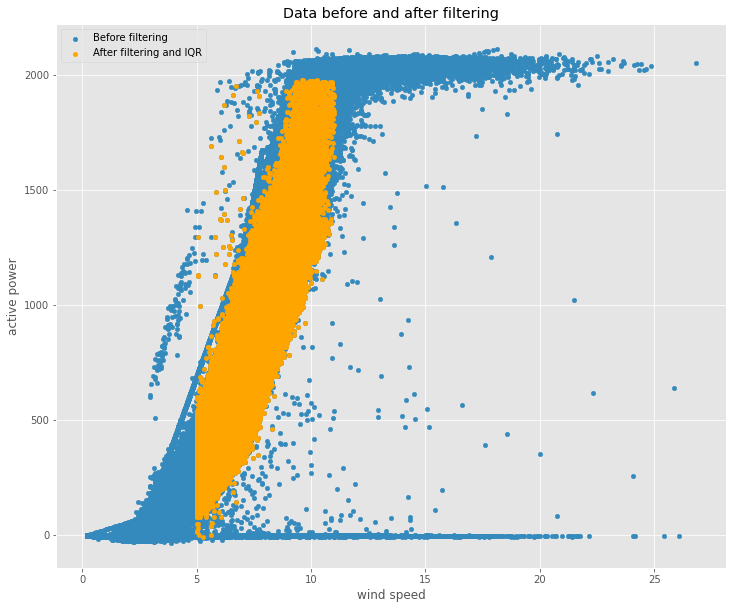

In [6]:
ax1=df_initial.plot.scatter(x='wind speed', y='active power', figsize=(12, 10), label='Before filtering')
df.plot.scatter(ax=ax1, x='wind speed', y='active power', c='orange', label = 'After filtering and IQR')
plt.title("Data before and after filtering")
plt.show()

# Print statistics

In [7]:
df.describe()

,wind speed,pitch angle,rotor speed,active power,nacelle direction,wind direction,theta_d
count,136192.000000,136192.000000,136192.000000,136192.000000,136192.000000,136192.000000,136192.000000
mean,6.745582,0.115850,11.500082,636.510784,192.138946,191.704210,-0.508339
std,1.262823,0.293845,1.512116,368.726568,89.437401,86.059437,5.738693
min,5.000024,0.000000,8.112732,-9.336444,0.519865,1.220752,-18.012062
25%,5.734942,0.000000,10.456061,345.856172,137.823743,135.960048,-3.584244
50%,6.498056,0.000000,11.634141,545.085348,188.243683,189.465970,-0.231389
75%,7.514249,0.000000,12.171931,854.621911,254.097565,246.085835,2.880218
max,10.997084,1.999871,14.999933,1976.667560,359.498288,357.642532,16.937191


# Print correlations

In [8]:
df.corr()

,wind speed,pitch angle,rotor speed,active power,nacelle direction,wind direction,theta_d
wind speed,1.000000,0.581065,0.760827,0.901873,-0.129175,-0.136687,-0.049703
pitch angle,0.581065,1.000000,0.279682,0.643454,-0.113414,-0.117088,0.007301
rotor speed,0.760827,0.279682,1.000000,0.842910,-0.152793,-0.155248,0.010000
active power,0.901873,0.643454,0.842910,1.000000,-0.189744,-0.197258,-0.037224
nacelle direction,-0.129175,-0.113414,-0.152793,-0.189744,1.000000,0.940266,-0.204712
wind direction,-0.136687,-0.117088,-0.155248,-0.197258,0.940266,1.000000,-0.151792
theta_d,-0.049703,0.007301,0.010000,-0.037224,-0.204712,-0.151792,1.000000


# Remove outliers using the iQR method and Local Outlier Factor

In [9]:
def outliers_LoF(df):
    clf = LocalOutlierFactor(n_neighbors=300, n_jobs=16)
    res = clf.fit_predict(df)
    df = df[res == 1]
    return df


In [10]:
df_outliers = df.copy()
df = outliers_LoF(df).copy()
print(df.shape)

(133339, 7)


In [11]:
# TODO filtering and iqr fix

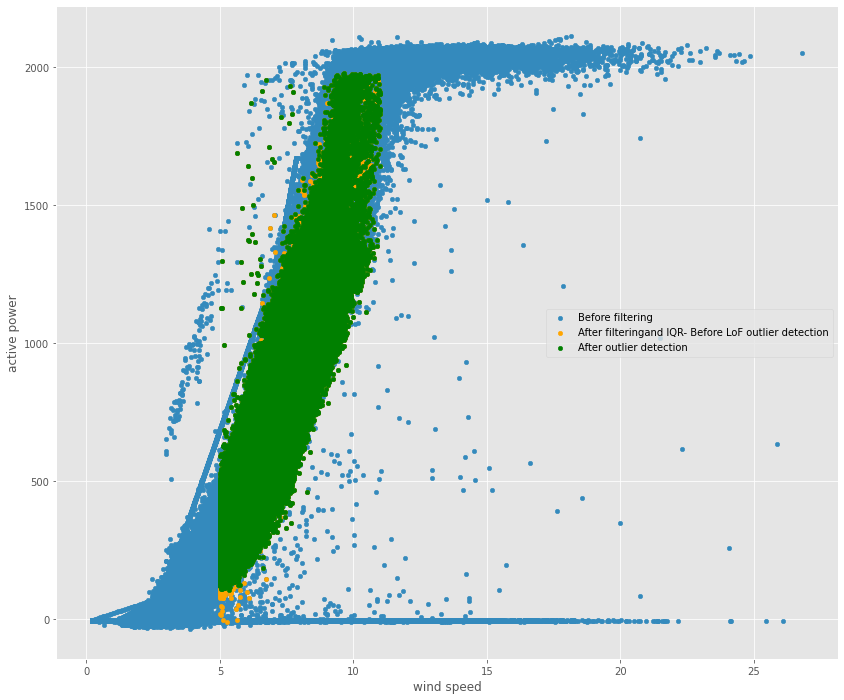

In [12]:
ax1 = df_initial.plot.scatter(x='wind speed', y='active power', figsize=(14, 12), label='Before filtering')
ax1 = df_outliers.plot.scatter(ax =ax1, x='wind speed', y='active power', c='orange', figsize=(14, 12), label='After filteringand IQR- Before LoF outlier detection')
df.plot.scatter(ax=ax1, x='wind speed', y='active power', c='green', label = 'After outlier detection')
plt.show()

# Add a column with the measured static yaw misalignment

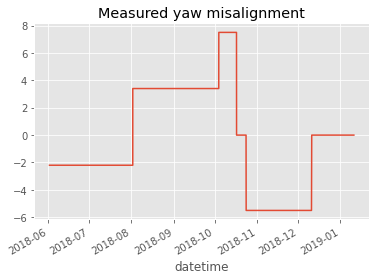

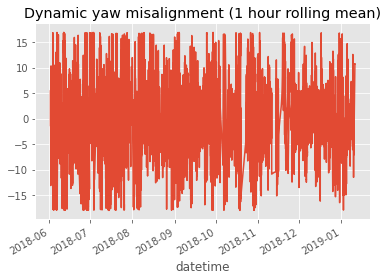

In [13]:
df["y"] = np.nan
m1 = (df.index >= '2018-10-17') & (df.index < '2018-10-24')
m2 = (df.index >= '2018-12-11')
date_masks = [(df.index < '2018-08-02'),
              (df.index >= '2018-08-02') & (df.index < '2018-10-04'),
              (df.index >= '2018-10-04') & (df.index < '2018-10-17'),
              (df.index >= '2018-10-17') & (df.index < '2018-10-24'),
              (df.index >= '2018-10-24') & (df.index < '2018-12-11'),
              (df.index >= '2018-12-11')]


#static_misalignment_values = [-6.7, 4.8, 9.4, 0, -5.8, 0] # BBZ1

#static_misalignment_values = [2.7, 2.7, 4.9, 0, -5.1, 0] # BBZ2

static_misalignment_values = [-2.2, 3.4, 7.5, 0, -5.5, 0] # BBZ3


for m, s in zip(date_masks, static_misalignment_values):
    df.loc[m, 'y'] = s
df['y'].plot()
plt.title("Measured yaw misalignment")
plt.show()

df['theta_d'].plot()
plt.title("Dynamic yaw misalignment (1 hour rolling mean)")
plt.show()

### Split dataset into bins based on wind speed

In [14]:
bin_size = 0.5
min_speed = 5
max_speed = 11
bins = np.arange(min_speed, max_speed, bin_size)
bins = np.append(bins,max_speed)
print(bins)
bin_masks = []
bin_feature = 'wind speed'
for i in range(len(bins) - 1):
    mask = (df[bin_feature]>= bins[i]) & (df[bin_feature] < bins[i + 1])
    bin_masks.append(mask)

[ 5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11. ]


# Estimate the yaw angle using a weighted average of the predicted angles

In [15]:
n_most_freq = None # choose how many of the most frequent values will be used in the weighted average None -> use all values

### Wind speed only

[-2.2, 3.4, 7.5, 0, 0]


  0%|          | 0/4 [00:00<?, ?it/s]

{'-2.2': {'-6.7': 0.03821917482729911, '0.0': 0.14996814641921394, '4.8': 0.038145209478167894, '9.4': 0.05024829781628315}, '0.0': {'-6.7': 0.1444963468282107, '0.0': 0.0559415347100604, '4.8': 0.16640785781327935, '9.4': 0.19798367542258813}, '3.4': {'-6.7': 0.041766018533643236, '0.0': 0.1519544672534727, '4.8': 0.04936367319565924, '9.4': 0.05512926852106201}, '7.5': {'-6.7': 0.050588701576790865, '0.0': 0.1779809949467502, '4.8': 0.04352579263517556, '9.4': 0.041236352536414715}}
-2.2
For bin 0 in the regions with ground truth angle -2.2
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [ 146 1730 2500 2957]

For bin 1 in the regions with ground truth angle -2.2
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [ 120 1594 2449 2592]

For bin 2 in the regions with ground truth angle -2.2
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [ 100 1363 2383 2210]

For bin 3 in the regions with ground truth 

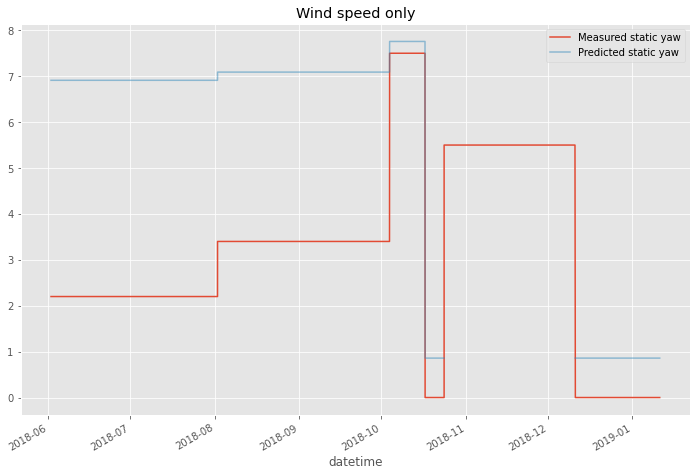

In [16]:
df_scaled = scale_df(df.copy())
df_scaled['y'] = df['y']
selected_features = ['wind speed', 'pitch angle', 'rotor speed']
models_file = 'trained_models_wind_speed.pickle' 
with open(models_file, 'rb') as file:
    models_dict = pickle.load(file)
    
bin_feature = 'wind speed'
binned_data_dfs = []
for b in bin_masks:
    df_temp = df_scaled[b]
    binned_data_dfs.append(df_temp.copy())
    
fit_features = selected_features 
fit_features = ['wind speed']
target_feature = ['active power']
    
evaluation_scores = {}
evaluation_preds = {}
static_misalignment_values1 = [x for i, x in enumerate(static_misalignment_values) if i != 4]
print(static_misalignment_values1)
for theta_s in tqdm(np.unique(static_misalignment_values1)):
    #print(f'Working on {theta_s}')
    evaluation_scores[str(theta_s)] = {}
    evaluation_preds[str(theta_s)] = {}
    for key, models in models_dict.items():
        mape_list = []
        evaluation_preds[str(theta_s)][key] = {}
        #print(f'evaluating with models trained on {key}')
        for bin_n, d in enumerate(binned_data_dfs):
            d = d[d['y'] == theta_s].copy()
            if d.shape[0] >= 100 and models[bin_n] is not None:
                test_preds = predict(d, models[bin_n], fit_features, target_feature)
                r_sq, mae, me, mape, mpe = score(d[target_feature].values, test_preds)
                mape_list.append(mae)
                evaluation_preds[str(theta_s)][key][str(bin_n)] = test_preds
            else:
                evaluation_preds[str(theta_s)][key][str(bin_n)] = None
        avg_mape = np.mean(mape_list)
        evaluation_scores[str(theta_s)][key] = avg_mape
print(evaluation_scores)

# estimate the angle using a weighted average with the frequency of each point
result = {}
for th_s in np.unique(static_misalignment_values1): 
    print(th_s)
    average_for_each_bin = []
    for bin_n, d in enumerate(binned_data_dfs):
        d = d[d['y'] == th_s].copy()
        if d.shape[0] <= 100 or test_preds is None:
            continue
            
        # label each point in one bin to the closest prediction by the models of each angle of the bin
        label_per_bin = np.zeros(d[target_feature].shape) - 1
        diffs_per_bin = np.zeros(d[target_feature].shape) + np.inf # used to hold the minimum diffs until now
        l_test = np.zeros(d[target_feature].shape) - 1
        scoring_metrics = {}
        test_diffs = []
        for key, bin_dict in evaluation_preds[str(th_s)].items():
            # these are the predictions if the trained model corresponding to "key" angle/ in bin bin_n
            test_preds = bin_dict[str(bin_n)]
            if d.shape[0] >= 100 and test_preds is not None:
                # calculate the differences between the actual and predicted values (residuals)
                (r_sq, mae, me, mape, mpe) = score(d[target_feature].values, test_preds)
                temp_diff = np.abs(test_preds-d[target_feature].values)
                test_diffs.append(temp_diff.ravel())
#                 # unncomment line below for histograms of the differences for each bin for each model
#                 plt.hist(temp_diff, label=key, bins = 20)
#                 plt.axvline(temp_diff.mean(), color='k', linestyle='dashed', linewidth=1, label=f'mean of {key} = {temp_diff.mean():.3}')
#                 plt.legend()
#                 plt.show()
                mask = (temp_diff <= diffs_per_bin) # mask to find the points with current difference lower than the minimum
                diffs_per_bin[mask] = temp_diff[mask]
                scoring_metrics[str(np.abs(float(key)))] = (r_sq, mae, me, mape, mpe) # store metrics 
                label_per_bin[mask] = np.abs(float(key)) # assign labels
            else:
                pass
        unique, counts = np.unique(label_per_bin, return_counts=True)
        print(f"For bin {bin_n} in the regions with ground truth angle {th_s}")
        print(f"The distribution of prediction labels for the interval is:")
        print(unique, counts, end='\n\n')
        # barplot  with the frequencies of each label
#         plt.bar(np.arange(unique.shape[0]), counts)
#         plt.xticks(np.arange(unique.shape[0]), labels=unique)
#         plt.show()
        # calculate weighted average for each bin
        if n_most_freq is not None:
            idx = counts.argsort()[::-1][:n_most_freq]
            unique = unique[idx]
            counts = counts[idx]
        res = np.average(unique, weights=counts)
        average_for_each_bin.append(res)
    print("The weighted average (by frequency) of this bin is:")
    print(average_for_each_bin)
    print(np.mean(average_for_each_bin))
    result[str(th_s)] = np.mean(average_for_each_bin)
    
df['y_pred'] = np.nan
for th_s in np.unique(static_misalignment_values1): 
    df['y_pred'][df['y']==th_s] = result[str(th_s)]

prediction = np.abs(df['y_pred'])
target = np.abs(df['y'])

rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

target.plot(figsize=(12, 8), label = 'Measured static yaw')
prediction.plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Wind speed only')
plt.legend()
plt.show()







[-2.2, 3.4, 7.5, 0, 0]


  0%|          | 0/4 [00:00<?, ?it/s]

{'-2.2': {'-6.7': 0.03776456344913905, '0.0': 0.0628470277579392, '4.8': 0.03680379407798001, '9.4': 0.03661753592532415}, '0.0': {'-6.7': 0.08937985184344487, '0.0': 0.05061166538944538, '4.8': 0.09139073952578815, '9.4': 0.14130453446190366}, '3.4': {'-6.7': 0.04197155747628145, '0.0': 0.061914484249107636, '4.8': 0.04243616008536055, '9.4': 0.041264408646079255}, '7.5': {'-6.7': 0.04829146339824007, '0.0': 0.0660090715320167, '4.8': 0.0469060643753596, '9.4': 0.040374171335373105}}
-2.2
For bin 0 in the regions with ground truth angle -2.2
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [1178  663 2903 2589]

For bin 1 in the regions with ground truth angle -2.2
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [ 544  566  565 5080]

For bin 2 in the regions with ground truth angle -2.2
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [  94 1115  410 4437]

For bin 3 in the regions with ground truth 

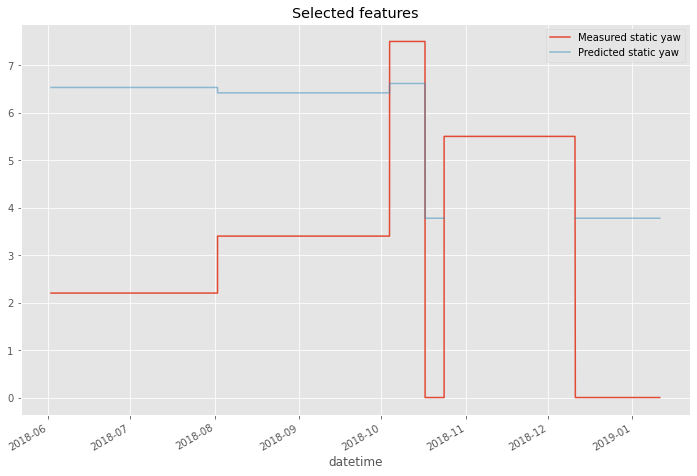

In [17]:
df_scaled = scale_df(df.copy())
df_scaled['y'] = df['y']
selected_features = ['wind speed', 'pitch angle', 'rotor speed']
models_file = 'trained_models_selected.pickle' 
with open(models_file, 'rb') as file:
    models_dict = pickle.load(file)
    
bin_feature = 'wind speed'
binned_data_dfs = []
for b in bin_masks:
    df_temp = df_scaled[b]
    binned_data_dfs.append(df_temp.copy())
    
fit_features = selected_features 
target_feature = ['active power']
    
evaluation_scores = {}
evaluation_preds = {}
static_misalignment_values1 = [x for i, x in enumerate(static_misalignment_values) if i != 4]
print(static_misalignment_values1)
for theta_s in tqdm(np.unique(static_misalignment_values1)):
    #print(f'Working on {theta_s}')
    evaluation_scores[str(theta_s)] = {}
    evaluation_preds[str(theta_s)] = {}
    for key, models in models_dict.items():
        mape_list = []
        evaluation_preds[str(theta_s)][key] = {}
        #print(f'evaluating with models trained on {key}')
        for bin_n, d in enumerate(binned_data_dfs):
            d = d[d['y'] == theta_s].copy()
            if d.shape[0] >= 100 and models[bin_n] is not None:
                test_preds = predict(d, models[bin_n], fit_features, target_feature)
                r_sq, mae, me, mape, mpe = score(d[target_feature].values, test_preds)
                mape_list.append(mae)
                evaluation_preds[str(theta_s)][key][str(bin_n)] = test_preds
            else:
                evaluation_preds[str(theta_s)][key][str(bin_n)] = None
        avg_mape = np.mean(mape_list)
        evaluation_scores[str(theta_s)][key] = avg_mape
print(evaluation_scores)

# estimate the angle using a weighted average with the frequency of each point
result = {}
for th_s in np.unique(static_misalignment_values1): 
    print(th_s)
    average_for_each_bin = []
    for bin_n, d in enumerate(binned_data_dfs):
        d = d[d['y'] == th_s].copy()
        if d.shape[0] <= 100 or test_preds is None:
            continue
            
        # label each point in one bin to the closest prediction by the models of each angle of the bin
        label_per_bin = np.zeros(d[target_feature].shape) - 1
        diffs_per_bin = np.zeros(d[target_feature].shape) + np.inf # used to hold the minimum diffs until now
        l_test = np.zeros(d[target_feature].shape) - 1
        scoring_metrics = {}
        test_diffs = []
        for key, bin_dict in evaluation_preds[str(th_s)].items():
            # these are the predictions if the trained model corresponding to "key" angle/ in bin bin_n
            test_preds = bin_dict[str(bin_n)]
            if d.shape[0] >= 100 and test_preds is not None:
                # calculate the differences between the actual and predicted values (residuals)
                (r_sq, mae, me, mape, mpe) = score(d[target_feature].values, test_preds)
                temp_diff = np.abs(test_preds-d[target_feature].values)
                test_diffs.append(temp_diff.ravel())
#                 # unncomment line below for histograms of the differences for each bin for each model
#                 plt.hist(temp_diff, label=key, bins = 20)
#                 plt.axvline(temp_diff.mean(), color='k', linestyle='dashed', linewidth=1, label=f'mean of {key} = {temp_diff.mean():.3}')
#                 plt.legend()
#                 plt.show()
                mask = (temp_diff <= diffs_per_bin) # mask to find the points with current difference lower than the minimum
                diffs_per_bin[mask] = temp_diff[mask]
                scoring_metrics[str(np.abs(float(key)))] = (r_sq, mae, me, mape, mpe) # store metrics 
                label_per_bin[mask] = np.abs(float(key)) # assign labels
            else:
                pass
        unique, counts = np.unique(label_per_bin, return_counts=True)
        print(f"For bin {bin_n} in the regions with ground truth angle {th_s}")
        print(f"The distribution of prediction labels for the interval is:")
        print(unique, counts, end='\n\n')
        # barplot  with the frequencies of each label
#         plt.bar(np.arange(unique.shape[0]), counts)
#         plt.xticks(np.arange(unique.shape[0]), labels=unique)
#         plt.show()
        # calculate weighted average for each bin
        if n_most_freq is not None:
            idx = np.argmax(counts)
            unique = unique[idx]
            counts = counts[idx]
        res = np.average(unique, weights=counts)
        average_for_each_bin.append(res)
    print("The weighted average (by frequency) of this bin is:")
    print(average_for_each_bin)
    print(np.mean(average_for_each_bin))
    result[str(th_s)] = np.mean(average_for_each_bin)
    
df['y_pred'] = np.nan
for th_s in np.unique(static_misalignment_values1): 
    df['y_pred'][df['y']==th_s] = result[str(th_s)]
    
prediction = np.abs(df['y_pred'])
target = np.abs(df['y'])

rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

target.plot(figsize=(12, 8), label = 'Measured static yaw')
prediction.plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Selected features')
plt.legend()
plt.show()







[-2.2, 3.4, 7.5, 0, 0]


  0%|          | 0/4 [00:00<?, ?it/s]

{'-2.2': {'-6.7': 0.032319455467391546, '0.0': 0.07974250325389567, '4.8': 0.04024194851300943, '9.4': 0.18988146523799848}, '0.0': {'-6.7': 0.09094101583385818, '0.0': 0.050637905867101395, '4.8': 0.0713932029781168, '9.4': 0.15329552679846362}, '3.4': {'-6.7': 0.029902320231394126, '0.0': 0.08882229885654185, '4.8': 0.0436609963753713, '9.4': 0.0738939412365988}, '7.5': {'-6.7': 0.029237664074514023, '0.0': 0.11585556580141272, '4.8': 0.04280026900735702, '9.4': 0.04268071687446784}}
-2.2
For bin 0 in the regions with ground truth angle -2.2
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [1128 2099 3137  969]

For bin 1 in the regions with ground truth angle -2.2
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [ 332 1393 1355 3675]

For bin 2 in the regions with ground truth angle -2.2
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [ 210 1650  790 3406]

For bin 3 in the regions with ground truth

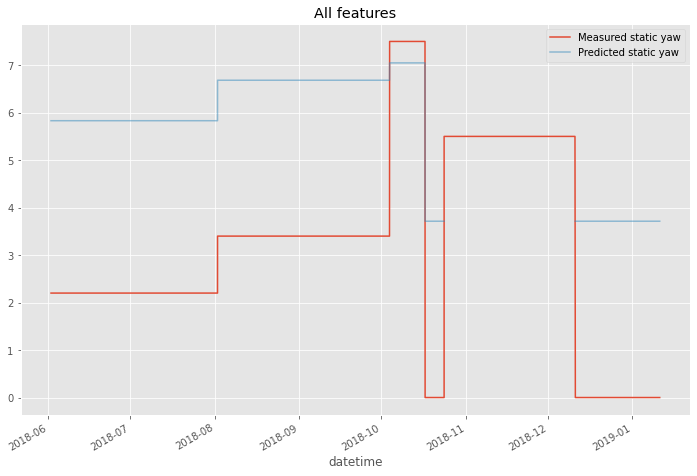

In [18]:
df_scaled = scale_df(df.copy())
df_scaled['y'] = df['y']
selected_features = ['wind speed', 'pitch angle', 'rotor speed']
models_file = 'trained_models_all.pickle' 
with open(models_file, 'rb') as file:
    models_dict = pickle.load(file)
    
bin_feature = 'wind speed'
binned_data_dfs = []
for b in bin_masks:
    df_temp = df_scaled[b]
    binned_data_dfs.append(df_temp.copy())
    
fit_features = ['wind speed', 'pitch angle', 'rotor speed', 'nacelle direction', 'wind direction', 'theta_d']
target_feature = ['active power']
    
evaluation_scores = {}
evaluation_preds = {}
static_misalignment_values1 = [x for i, x in enumerate(static_misalignment_values) if i != 4]
print(static_misalignment_values1)
for theta_s in tqdm(np.unique(static_misalignment_values1)):
    #print(f'Working on {theta_s}')
    evaluation_scores[str(theta_s)] = {}
    evaluation_preds[str(theta_s)] = {}
    for key, models in models_dict.items():
        mape_list = []
        evaluation_preds[str(theta_s)][key] = {}
        #print(f'evaluating with models trained on {key}')
        for bin_n, d in enumerate(binned_data_dfs):
            d = d[d['y'] == theta_s].copy()
            if d.shape[0] >= 100 and models[bin_n] is not None:
                test_preds = predict(d, models[bin_n], fit_features, target_feature)
                r_sq, mae, me, mape, mpe = score(d[target_feature].values, test_preds)
                mape_list.append(mae)
                evaluation_preds[str(theta_s)][key][str(bin_n)] = test_preds
            else:
                evaluation_preds[str(theta_s)][key][str(bin_n)] = None
        avg_mape = np.mean(mape_list)
        evaluation_scores[str(theta_s)][key] = avg_mape
print(evaluation_scores)

# estimate the angle using a weighted average with the frequency of each point
result = {}
for th_s in np.unique(static_misalignment_values1): 
    print(th_s)
    average_for_each_bin = []
    for bin_n, d in enumerate(binned_data_dfs):
        d = d[d['y'] == th_s].copy()
        if d.shape[0] <= 100 or test_preds is None:
            continue
            
        # label each point in one bin to the closest prediction by the models of each angle of the bin
        label_per_bin = np.zeros(d[target_feature].shape) - 1
        diffs_per_bin = np.zeros(d[target_feature].shape) + np.inf # used to hold the minimum diffs until now
        l_test = np.zeros(d[target_feature].shape) - 1
        scoring_metrics = {}
        test_diffs = []
        for key, bin_dict in evaluation_preds[str(th_s)].items():
            # these are the predictions if the trained model corresponding to "key" angle/ in bin bin_n
            test_preds = bin_dict[str(bin_n)]
            if d.shape[0] >= 100 and test_preds is not None:
                # calculate the differences between the actual and predicted values (residuals)
                (r_sq, mae, me, mape, mpe) = score(d[target_feature].values, test_preds)
                temp_diff = np.abs(test_preds-d[target_feature].values)
                test_diffs.append(temp_diff.ravel())
#                 # unncomment line below for histograms of the differences for each bin for each model
#                 plt.hist(temp_diff, label=key, bins = 20)
#                 plt.axvline(temp_diff.mean(), color='k', linestyle='dashed', linewidth=1, label=f'mean of {key} = {temp_diff.mean():.3}')
#                 plt.legend()
#                 plt.show()
                mask = (temp_diff <= diffs_per_bin) # mask to find the points with current difference lower than the minimum
                diffs_per_bin[mask] = temp_diff[mask]
                scoring_metrics[str(np.abs(float(key)))] = (r_sq, mae, me, mape, mpe) # store metrics 
                label_per_bin[mask] = np.abs(float(key)) # assign labels
            else:
                pass
        unique, counts = np.unique(label_per_bin, return_counts=True)
        print(f"For bin {bin_n} in the regions with ground truth angle {th_s}")
        print(f"The distribution of prediction labels for the interval is:")
        print(unique, counts, end='\n\n')
        # barplot  with the frequencies of each label
#         plt.bar(np.arange(unique.shape[0]), counts)
#         plt.xticks(np.arange(unique.shape[0]), labels=unique)
#         plt.show()
        # calculate weighted average for each bin
        if n_most_freq is not None:
            idx = np.argmax(counts)
            unique = unique[idx]
            counts = counts[idx]
        res = np.average(unique, weights=counts)
        average_for_each_bin.append(res)
    print("The weighted average (by frequency) of this bin is:")
    print(average_for_each_bin)
    print(np.mean(average_for_each_bin))
    result[str(th_s)] = np.mean(average_for_each_bin)
    
df['y_pred'] = np.nan
for th_s in np.unique(static_misalignment_values1): 
    df['y_pred'][df['y']==th_s] = result[str(th_s)]

prediction = np.abs(df['y_pred'])
target = np.abs(df['y'])

rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

target.plot(figsize=(12, 8), label = 'Measured static yaw')
prediction.plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('All features')
plt.legend()
plt.show()





